# TP n°2 : Webscraping


Votre objectif est d'arriver à extraire le maximum de données de [ce site](https://books.toscrape.com/).



In [29]:
import pandas as pd 
import requests
import re
from bs4 import BeautifulSoup

## 0. Inspecter le site

Depuis votre navigateur, inspecter le site pour comprendre sa structure : 

- inspecter le code HTML avec DevTools
- changez de page pour voir l'effet sur l'url
- bref : appuyez un peu partout pour comprendre comment ça marche !

## 1. Scraper la première page

Depuis la [page d'acceuil](https://books.toscrape.com/) extraire pour chaque livre son :

    - titre
    - nombre d'étoiles
    - prix

Vous mettrez le résultat dans une ```DataFrame```.

### 1.1. On peut commencer par trouver les blocs correspondants à un livre

L'inspection du html nous montre que tous les blocs ont le même nom de classe ```"col-xs-6 col-sm-4 col-md-3 col-lg-3"```.

On peut donc extraire tous les éléments correspondant dans la réponse de notre requête.

In [30]:
url = "https://books.toscrape.com/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

books = soup.find_all("li", class_="col-xs-6 col-sm-4 col-md-3 col-lg-3")

print(f'{len(books)} livres trouvés')


20 livres trouvés


Et on voit que chaque livre est encapsulé dans ce code : 

```html
<li class="col-xs-6 col-sm-4 col-md-3 col-lg-3">
<article class="product_pod">
<div class="image_container">
<a href="catalogue/a-light-in-the-attic_1000/index.html"><img alt="A Light in the Attic" class="thumbnail" src="media/cache/2c/da/2cdad67c44b002e7ead0cc35693c0e8b.jpg"/></a>
</div>
<p class="star-rating Three">
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
<i class="icon-star"></i>
</p>
<h3><a href="catalogue/a-light-in-the-attic_1000/index.html" title="A Light in the Attic">A Light in the ...</a></h3>
<div class="product_price">
<p class="price_color">Â£51.77</p>
<p class="instock availability">
<i class="icon-ok"></i>
    
        In stock
    
</p>
<form>
<button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button>
</form>
</div>
</article>
</li>


```

### 1.2. Récupérer le titre

En inspectant le code, on voit que ça correspond à ça : 

```html
<h3>
    <a href="catalogue/a-light-in-the-attic_1000/index.html"
    title="A Light in the Attic">
    A Light in the ...</a>
</h3>
```

On veut donc récupérer l'attribut ```title``` de la balise ```a``` issue de la balise ```h3```.

On peut tester sur le premier livre :

In [31]:
books[0].find("h3").find("a").get("title")

'A Light in the Attic'

Et on vérifie que ca marche bien sur tous les livres

In [32]:
titles = []

for book in books:

    title = book.find("h3").find("a").get("title")
    titles.append(title)

titles

['A Light in the Attic',
 'Tipping the Velvet',
 'Soumission',
 'Sharp Objects',
 'Sapiens: A Brief History of Humankind',
 'The Requiem Red',
 'The Dirty Little Secrets of Getting Your Dream Job',
 'The Coming Woman: A Novel Based on the Life of the Infamous Feminist, Victoria Woodhull',
 'The Boys in the Boat: Nine Americans and Their Epic Quest for Gold at the 1936 Berlin Olympics',
 'The Black Maria',
 'Starving Hearts (Triangular Trade Trilogy, #1)',
 "Shakespeare's Sonnets",
 'Set Me Free',
 "Scott Pilgrim's Precious Little Life (Scott Pilgrim #1)",
 'Rip it Up and Start Again',
 'Our Band Could Be Your Life: Scenes from the American Indie Underground, 1981-1991',
 'Olio',
 'Mesaerion: The Best Science Fiction Stories 1800-1849',
 'Libertarianism for Beginners',
 "It's Only the Himalayas"]

### 1.4. Récupérer le nombre d'étoiles

Chaque livre a un bloc qui correspond à ça  : 

```html
<p class="star-rating Three">
    <i class="icon-star"></i>
    <i class="icon-star"></i>
    <i class="icon-star"></i>
    <i class="icon-star"></i>
    <i class="icon-star"></i>
</p>
```

Le problème : si un livre à deux étoiles, son code sera : 

```html
<p class="star-rating Two">
    <i class="icon-star"></i>
    <i class="icon-star"></i>
    <i class="icon-star"></i>
    <i class="icon-star"></i>
    <i class="icon-star"></i>
</p>
```

Il faudra donc traiter ce problème. Pour l'instant on veut récupérer le nom de la classe ```star-rating XXX``` de la balise ```p```.

On peut tester encore sur le premier livre.

In [33]:
books[0].find("p")["class"]

['star-rating', 'Three']

Pour isoler le nombre d'étoiles, il suffit donc de prendre le premier élément de la réponse.

In [34]:
books[0].find("p")["class"][1]

'Three'

On peut créer un dictionnaire pour mapper la représenation décimale (3) d'un nombre à son écriture (Three) et tester sur tous nos livres.

In [35]:
dict_map = {
    "One": 1,
    "Two": 2,
    "Three": 3,
    "Four": 4,
    "Five": 5
}

nb_stars = []
for book in books: 

    nb_star_letter = book.find("p")["class"][1]
    nb_star_number = dict_map[nb_star_letter]

    nb_stars.append(nb_star_number)

nb_stars


[3, 1, 1, 4, 5, 1, 4, 3, 4, 1, 2, 4, 5, 5, 5, 3, 1, 1, 2, 2]

### 1.5. Récupérer le prix

On peut isoler ce bout de code :

```html
<p class="price_color">Â£51.77</p>
```

On veut donc chercher le **texte** de la balise ```p``` dont la classe est ```price-color```. 

In [36]:
books[0].find("p", class_="price_color")

<p class="price_color">Â£51.77</p>

In [37]:
books[0].find("p", class_="price_color").get_text()

'Â£51.77'

On a notre résultat mais mal formaté : on ne veut garder que **51.77** ici. 

Plusieurs solutions sont possibles ici : 

- traitement de chaîne de caractère avec replace >> OK, simple
- traitement de chaîne de caractère comme une liste >> attention aux edge cases
- regex >> robuste

In [38]:
price = books[0].find("p", class_="price_color").get_text()
print("Texte original :", price)
r"\d+(\.\d+)?"
print(price.replace("Â£", ""))
print(price[2:])

# plusieurs chiffres éventuellement suivis d'un point et de plusieurs chiffres
pattern = r"\d+(?:\.\d+)?"
print(re.findall(pattern, price))

Texte original : Â£51.77
51.77
51.77
['51.77']


On peut itérer sur tous nos livres 

In [39]:
prices = []
for book in books:

    price_ = book.find("p", class_="price_color").get_text()
    price = price_.replace("Â£", "")

    prices.append(float(price))

prices

[51.77,
 53.74,
 50.1,
 47.82,
 54.23,
 22.65,
 33.34,
 17.93,
 22.6,
 52.15,
 13.99,
 20.66,
 17.46,
 52.29,
 35.02,
 57.25,
 23.88,
 37.59,
 51.33,
 45.17]

### 1.6. Version synthétique et ```DataFrame```

In [40]:
url = "https://books.toscrape.com/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

books = soup.find_all("li", class_="col-xs-6 col-sm-4 col-md-3 col-lg-3")

dict_map = {
    "One": 1,
    "Two": 2,
    "Three": 3,
    "Four": 4,
    "Five": 5
}


rows = []

for book in books:

    title = book.find("h3").find("a").get("title")

    nb_star_letter = book.find("p")["class"][1]
    nb_star_number = dict_map[nb_star_letter]

    price_ = book.find("p", class_="price_color").get_text()
    price = float(price_.replace("Â£", ""))

    rows.append({
    "title": title,
    "price": price,
    "rating": nb_star_number})

df = pd.DataFrame(rows)

df

,title,price,rating
0,A Light in the Attic,51.77,3
1,Tipping the Velvet,53.74,1
2,Soumission,50.10,1
3,Sharp Objects,47.82,4
4,Sapiens: A Brief History of Humankind,54.23,5
5,The Requiem Red,22.65,1
6,The Dirty Little Secrets of Getting Your Dream...,33.34,4
7,The Coming Woman: A Novel Based on the Life of...,17.93,3
8,The Boys in the Boat: Nine Americans and Their...,22.60,4
9,The Black Maria,52.15,1


## 2. Scraper la première page advanced

En creusant un peu dans le code, modifiez votre script pour pouvoir avoir :

- nb d'exemplaires disponibles
- upc (correspond à un id unique)
- catégorie
- nb reviews


### 2.1. Aller sur la fiche produit

Lorsque l'on clique sur une image, on arrive sur la fiche produit du livre : c'est donc qu'un lien url vers cette fiche est quelque part dans le code ! 

En inspectant on trouve : 

```html
<h3>
    <a href="catalogue/a-light-in-the-attic_1000/index.html"
    title="A Light in the Attic">
    A Light in the ...</a>
</h3>
```

On cherche donc la valeur ```href``` de la balise ```a``` incluse dans la balise ```h3```.

In [41]:
books[1].find("h3").find("a")["href"]

'catalogue/tipping-the-velvet_999/index.html'

On remarque que cet url n'est pas complète : il manque la base du site.

Une fois l'url complet, on peut le requêter comme vu précédemment

In [42]:
url_produit = "https://books.toscrape.com/" + books[0].find("h3").find("a")["href"]

response_produit = requests.get(url_produit)
soup_produit = BeautifulSoup(response_produit.text, "html.parser")

soup_produit


<!DOCTYPE html>

<!--[if lt IE 7]>      <html lang="en-us" class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html lang="en-us" class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html lang="en-us" class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]><!--> <html class="no-js" lang="en-us"> <!--<![endif]-->
<head>
<title>
    A Light in the Attic | Books to Scrape - Sandbox
</title>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="24th Jun 2016 09:29" name="created"/>
<meta content="
    It's hard to imagine a world without A Light in the Attic. This now-classic collection of poetry and drawings from Shel Silverstein celebrates its 20th anniversary with this special edition. Silverstein's humorous and creative verse can amuse the dowdiest of readers. Lemon-faced adults and fidgety kids sit still and read these rhythmic words and laugh and smile and love th It's hard to imagine a world without A Light in the Attic. Th

### 2.2. Récupérer les informations

On veut extraire : 

- UPC
- nb exemplaires
- catégorie
- nb_reviews

On peut les repérer sur le site : 

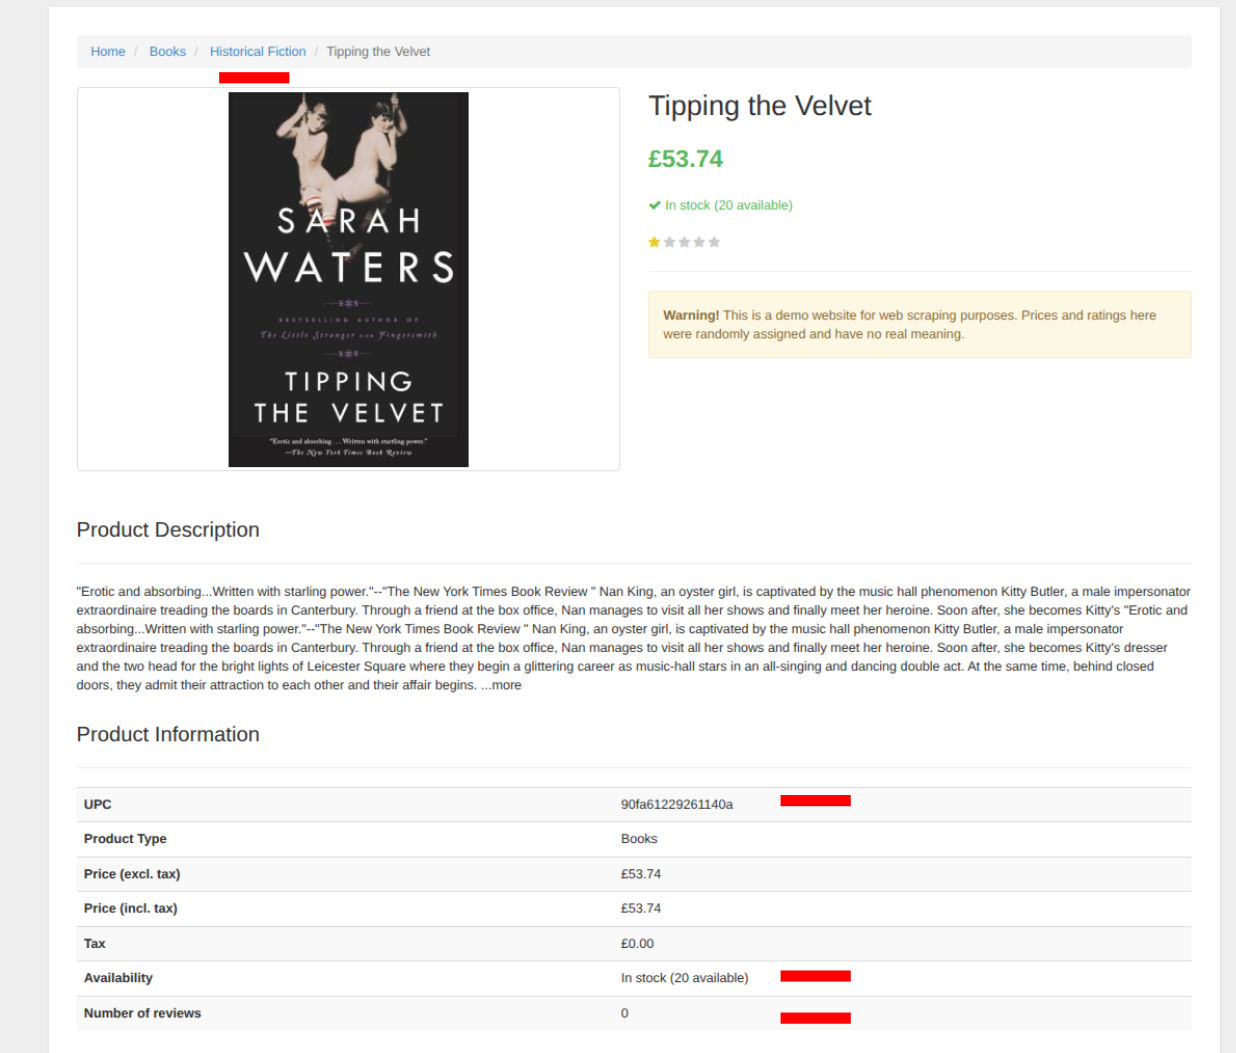

#### 2.2.1. Catégorie

On isole le code suivant :

```html
<ul class="breadcrumb">
    <li>
        <a href="../../index.html">Home</a>
    </li>
    
    <li>
        <a href="../category/books_1/index.html">Books</a>
    </li>
    
    <li>
        <a href="../category/books/historical-fiction_4/index.html">Historical Fiction</a>
    </li>
    
    <li class="active">Tipping the Velvet</li> 
</ul>
```

On veut donc le texte du troisième élement ```li``` de l'élément ```ul``` dont la classe est ```breadcrumb```.

In [43]:
soup_produit.find("ul", class_="breadcrumb").find_all("li")[2].get_text()

'\nPoetry\n'

On peut enlever les newlines assez simplement 

In [44]:
soup_produit.find("ul", class_="breadcrumb").find_all("li")[2].get_text().strip("\n")

'Poetry'

#### 2.2.2. UPC

L'id unique de chaque livre est dans ce code : 

```html
<table class="table table-striped">
                    <tr>
                <th>UPC</th>
                <td>90fa61229261140a</td>
            </tr>
        .....
    </tbody>
</table>
```

Il u a beaucup de manières de faire , je vous propose celle là :

In [45]:
soup_produit.find("table", class_="table").find_all("td")[0].get_text()

'a897fe39b1053632'

#### 2.2.3. Nombre de revues

In [46]:
soup_produit.find("table", class_="table").find_all("td")[-1].get_text()

'0'

#### 2.2.4. Nombre de livres disponibles

In [47]:
soup_produit.find("table", class_="table").find_all("td")[-2].get_text()

'In stock (22 available)'

On doit donc retraiter un peu notre chaîne de caractère, je vous propose cette méthode

In [48]:
stocks = soup_produit.find("table", class_="table").find_all("td")[-2].get_text()

print(stocks.replace("In stock (","").replace(" available)", ""))
print(re.search(r"\d+" # plusieurs chiffres
                , stocks).group(0))

22
22


### 2.3. Code complet pour un livre

Pour pouvoir intelligement réutiliser ce code, on peut définir une fonction qui part d'un "bloc livre" dans la page d'acceuil et qui retourne toutes les informations. 

In [49]:
type(book)

bs4.element.Tag

In [70]:
import bs4

def get_information_from_book_page(book : bs4.element.Tag) -> dict:
    """
    Informations présentes sur la fiche produit d'un livre

    book : bloc de code html correspondant au livre sur la home page
    """
    # certains href n'ont pas de "catalog/"
    url_produit = book.find("h3").find("a")["href"]

    if "catalogue" not in url_produit:
        url_produit = "catalogue/" + url_produit
    url_base = "https://books.toscrape.com/"

    url = url_base + url_produit

    # extrait l'url et le requête puis le parse
    response_produit = requests.get(url)
    soup_produit = BeautifulSoup(response_produit.text, "html.parser")

    # extrait les infos
    category = soup_produit.find("ul", class_="breadcrumb").find_all("li")[2].get_text().strip("\n")
    nb_revues = int(soup_produit.find("table", class_="table").find_all("td")[-1].get_text())
    upc = soup_produit.find("table", class_="table").find_all("td")[0].get_text()
    
    stocks_ = soup_produit.find("table", class_="table").find_all("td")[-2].get_text()

    stocks = int(re.search(r"\d+" # plusieurs chiffres
                    , stocks_).group(0))

    # formatte en dict pour pouvoir le mettre facilement dans une df
    return {
        "upc" : upc,
        "category" : category,
        "stocks":stocks,
        "nb_revues": nb_revues
    }

get_information_from_book_page(books[0])


{'upc': 'a897fe39b1053632', 'category': 'Poetry', 'stocks': 22, 'nb_revues': 0}

Pour aller plus loin dans la modularité, on peut même créer une fonction plus complète qui charge les infos de la home page et de la fiche produit du livre.

In [71]:
def scrape_book_info(book : bs4.element.Tag) -> dict:

    title = book.find("h3").find("a").get("title")

    nb_star_letter = book.find("p")["class"][1]
    nb_star_number = dict_map[nb_star_letter]

    price_ = book.find("p", class_="price_color").get_text()
    price = float(price_.replace("Â£", ""))


    infos_book_page = get_information_from_book_page(book)

    book_dict = {
        "title": title,
        "price": price,
        "rating": nb_star_number,
        **infos_book_page  # unpack du dict renvoyé par get_information_from_book_page
    }

    return book_dict

scrape_book_info(books[0])

{'title': 'A Light in the Attic',
 'price': 51.77,
 'rating': 3,
 'upc': 'a897fe39b1053632',
 'category': 'Poetry',
 'stocks': 22,
 'nb_revues': 0}

### 2.4. Code pour tous les livres de la première page

C'est maintenant beaucoup plus simple de scraper tous les livres !

In [72]:
rows = []
for book in books:

    rows.append(scrape_book_info(book))

df = pd.DataFrame(rows)

df

,title,price,rating,upc,category,stocks,nb_revues
0,A Light in the Attic,51.77,3,a897fe39b1053632,Poetry,22,0
1,Tipping the Velvet,53.74,1,90fa61229261140a,Historical Fiction,20,0
2,Soumission,50.10,1,6957f44c3847a760,Fiction,20,0
3,Sharp Objects,47.82,4,e00eb4fd7b871a48,Mystery,20,0
4,Sapiens: A Brief History of Humankind,54.23,5,4165285e1663650f,History,20,0
5,The Requiem Red,22.65,1,f77dbf2323deb740,Young Adult,19,0
6,The Dirty Little Secrets of Getting Your Dream...,33.34,4,2597b5a345f45e1b,Business,19,0
7,The Coming Woman: A Novel Based on the Life of...,17.93,3,e72a5dfc7e9267b2,Default,19,0
8,The Boys in the Boat: Nine Americans and Their...,22.60,4,e10e1e165dc8be4a,Default,19,0
9,The Black Maria,52.15,1,1dfe412b8ac00530,Poetry,19,0


## 3. Scraper les 1000 livres du site 

Maintenant, appliquez la même logique pour scrapper tous les livres du site. 

Le résultat final sera stocké dans une ```DataFrame```.


On remarque que le site a plusieurs pages. Celles si sont identifiées par des urls du type : 

```
https://books.toscrape.com/index.html (home page)
https://books.toscrape.com/catalogue/page-2.html
https://books.toscrape.com/catalogue/page-3.html
```

En testant pour la home page, on se rend compte que 

```
https://books.toscrape.com/catalogue/page-1.html
```

fonctionne aussi. 

Nous avons déjà la logique pour tout extraire à partir d'une page, il nous suffit donc de le faire pour toutes les pages !

In [ ]:
rows = []
#for i in range(1, 51):
# pour ne pas prendre trop de temps, on fait un exemple sur 2 pages
for i in range(1, 3):

    # on construit l'url de la page
    url = "https://books.toscrape.com/catalogue/page-" + str(i) + ".html"

    # on la requête et on parse chaque livre
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    books = soup.find_all("li", class_="col-xs-6 col-sm-4 col-md-3 col-lg-3")

    for book in books:

        row = scrape_book_info(book)
        rows.append(row)


df = pd.DataFrame(rows)

df

,title,price,rating,upc,category,stocks,nb_revues
0,A Light in the Attic,51.77,3,a897fe39b1053632,Poetry,22,0
1,Tipping the Velvet,53.74,1,90fa61229261140a,Historical Fiction,20,0
2,Soumission,50.10,1,6957f44c3847a760,Fiction,20,0
3,Sharp Objects,47.82,4,e00eb4fd7b871a48,Mystery,20,0
4,Sapiens: A Brief History of Humankind,54.23,5,4165285e1663650f,History,20,0
5,The Requiem Red,22.65,1,f77dbf2323deb740,Young Adult,19,0
6,The Dirty Little Secrets of Getting Your Dream...,33.34,4,2597b5a345f45e1b,Business,19,0
7,The Coming Woman: A Novel Based on the Life of...,17.93,3,e72a5dfc7e9267b2,Default,19,0
8,The Boys in the Boat: Nine Americans and Their...,22.60,4,e10e1e165dc8be4a,Default,19,0
9,The Black Maria,52.15,1,1dfe412b8ac00530,Poetry,19,0


## 4. Analyses

Maintenant qu'on a la donnée, on peut l'utiliser ! 

Répondez avec ```pandas``` aux questions suivantes :

  - quel est le prix moyen d'un livre ?
  - quel est le livre le plus cher ? Le moins cher ? 
  - combien de livres ont 1 étoiles ? 2 étoiles ? ... 
  - quel est la catégorie la plus représentée ?
  - est ce qu'il y a un lien entre le prix d'un livre et son nombre d'étoiles ? 
  - quelle est la [distribution d'occurence des lettres de l'alphabet dans les titres](https://fr.wikipedia.org/wiki/Fr%C3%A9quence_d%27apparition_des_lettres) ? 
  - quels sont les mots les plus utilisés ([cf. loi de Zipf](https://fr.wikipedia.org/wiki/Loi_de_Zipf))

In [ ]:
## votre code ici